## 1. Постановка задачи


В данном проекте вы решите настоящую бизнес-задачу в области маркетинга. Вам предстоит произвести сегментацию клиентов на основе их покупательской способности, частоты совершения заказов и срока давности последнего заказа, а также определить оптимальную стратегию взаимодействия с ними.
<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

Маркетинг — неотъемлемая часть любого бизнеса. Для повышения прибыли компании важно понимать своего клиента, его пожелания и предпочтения. С появлением электронной коммерции, или онлайн-продаж, стало намного проще собирать данные о клиентах, анализировать их, находить закономерности и реализовывать маркетинговые кампании.

Большинство интернет-магазинов используют инструменты веб-аналитики, чтобы отслеживать просмотры страниц, количество и поведение посетителей и коэффициент отказов. Но отчёта из Google Analytics или аналогичной системы может быть недостаточно для полного понимания того, как клиенты взаимодействуют с сайтом. Компаниям важно иметь возможность быстро и точно реагировать на перемены в поведении клиентов, создавая инструменты, которые обнаруживают эти изменения практически в режиме реального времени.

Машинное обучение помогает поисковой системе анализировать огромное количество данных о посетителях платформы, узнавать модели поведения профессиональных покупателей, определять категорию клиентов (например, лояльные/перспективные/новички/спящие/ушедшие) и выбирать правильную стратегию взаимодействия с ними.

Стоит также отметить, что компании, использующие машинное обучение на своих платформах электронной коммерции, могут постоянно повышать эффективность бизнес-процессов: настраивать товарную выборку персонально для каждого покупателя и предлагать выгодную цену в соответствии с бюджетом клиента и т. д. Эта задача относится к категории построения рекомендательных систем, речь о которых пойдёт в следующем разделе нашего курса.

Как правило, наборы данных для электронной коммерции являются частной собственностью и, следовательно, их трудно найти среди общедоступных данных.

**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача для вас как для специалиста в Data Science:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку набора данных.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать категории товаров и клиентов.
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.



## 2. Знакомство с данными.

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

In [145]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Первым делом необходимо понять, с какими данными нам предстоит работать, и произвести базовую предобработку данных, переведя признаки в необходимые для дальнейшей работы форматы.


Для начала давайте познакомимся с нашими данными:

In [146]:
data = pd.read_csv(
    "/content/drive/My Drive/Marketing Segmentation/customer_segmentation_project.csv",
    encoding="ISO-8859-1",
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Итак, у нас есть данные о более чем полумиллионе транзакций. Каждая из них описывается следующими признаками:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* Stock Code — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию;
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.

Проведём анализ структуры таблицы.


### Задание 2.1
Сколько столбцов в данных кодируются числовыми типами (int/float)?

In [147]:
data.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,object
UnitPrice,float64
CustomerID,object
Country,object


### Задание 2.2
Выберите столбцы, в которых есть хотя бы один пропуск:
* InvoiceNo
* StockCode
* Description
* CustomerID
* Country

In [148]:
data[['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Country']].isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
CustomerID,135080
Country,0


### Задание 2.3
Судя по описанию задачи, нам должны были предоставить данные за годовой период — проверим, так ли это.

Преобразуйте столбец InvoiceDate в формат datetime.
Укажите, за какой промежуток времени представлены данные:

* 2010-12-01 to 2011-12-09
* 2011-12-01 to 2012-12-09
* 2010-01-01 to 2011-01-09
* 2020-12-01 to 2021-12-09


In [149]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

print("Минимальная дата:", data['InvoiceDate'].min())
print("Максимальная дата:", data['InvoiceDate'].max())

Минимальная дата: 2010-12-01 08:26:00
Максимальная дата: 2011-12-09 12:50:00


### Задание 2.4

1) Каково максимальное количество товаров в заказе (Quantity)? Ответ приведите в виде целого числа.

2) Каково минимальное количество товаров в заказе (Quantity)? Ответ приведите в виде целого числа.

3) Сколько, согласно данным, стоит самый дешёвый товар (за исключением товаров с отрицательной стоимостью)?

In [150]:
max_quantity = data['Quantity'].max()
print("Максимальное Quantity:", max_quantity)

min_quantity = data['Quantity'].min()
print("Минимальное Quantity:", min_quantity)

Максимальное Quantity: 80995
Минимальное Quantity: -80995


### Задание 2.5
1) Сколько уникальных клиентов покупали товары за период выгрузки датасета?

2) Сколько уникальных стран содержится в столбце Country (исключая специальный код 'Unspecified', обозначающий неопределенную страну)?

3) Укажите идентификатор самого популярного товара (StockCode):
* 85123A
* 64812
* 51242
* 24151B


In [151]:
unique_customers = data['CustomerID'].nunique()
print("Уникальных клиентов:", unique_customers)

unique_countries = data[data['Country'] != 'Unspecified']['Country'].nunique()
print("Уникальных стран (без 'Unspecified'):", unique_countries)

top_product = data['StockCode'].value_counts().idxmax()
print("Самый популярный товар:", top_product)

Уникальных клиентов: 4372
Уникальных стран (без 'Unspecified'): 37
Самый популярный товар: 85123A


## 3. Предобработка и очистка данных

На этом этапе нам предстоит подготовить наш датасет для дальнейшего моделирования, произведя очистку данных.


### Задание 3.1
Начнем с пропусков.

1) Сколько всего в таблице пропущенных значений?

2) Пропуски в столбце с идентификатором клиента и описанием товара свидетельствуют о некорректных/незавершённых транзакциях.

Удалите строки, содержащие пропуски в этих столбцах. Сколько строк осталось в таблице?



In [152]:
missing_total = data.isnull().sum().sum()
print("Всего пропущенных значений:", missing_total)

data_cleaned = data.dropna(subset=['CustomerID', 'Description'])
print("Строк после очистки:", data_cleaned.shape[0])

Всего пропущенных значений: 136534
Строк после очистки: 406829


### Задание 3.2
Следом за пропусками проверим наличие дубликатов.

1) Сколько в таблице полностью дублирующихся записей?

2) Удалите дубликаты из таблицы. Сколько строк осталось?



In [153]:
duplicate_count = data_cleaned.duplicated().sum()
print("Количество полных дубликатов:", duplicate_count)

data_cleaned = data_cleaned.drop_duplicates()
print("Строк после удаления дубликатов:", data_cleaned.shape[0])

Количество полных дубликатов: 5225
Строк после удаления дубликатов: 401604


Ранее мы заметили, что в столбце с количеством товара есть отрицательные значения. Давайте разберемся, откуда они взялись. Выведем первые 5 строк таблицы, в которой столбец Quantity меньше 0.

In [154]:
negative_quantity = data[(data['Quantity']<0)]
print('Count of entries with a negative number: {}'.format(negative_quantity.shape[0]))
negative_quantity.head()

Count of entries with a negative number: 10624


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


### Задание 3.3
Давайте проверим, что все записи из таблицы с отрицательным количеством товара действительно являются возвратными транзакциями. Если транзакция не является возвратом, но содержит отрицательное количество товара, это будет поводом считать её выбросом.

Сколько транзакций из таблицы negative_quantity не содержат в номере заказа признак возврата?

In [155]:
# Найдём записи с отрицательным количеством, но без 'C' в начале номера счета
invalid_negatives = negative_quantity[~negative_quantity['InvoiceNo'].str.startswith('C')]

print("Количество записей с отрицательным Quantity, но без 'C':", invalid_negatives.shape[0])

Количество записей с отрицательным Quantity, но без 'C': 1336


Давайте подробнее разберёмся с возвратами. Сейчас на каждый уникальный товар заведена отдельная строка в таблице — это мешает определить общее количество возвратов.

Чтобы подсчитать число возвратов, сначала необходимо определить, сколько уникальных товаров указано в транзакции (корзине/basket) для каждой уникальной пары «клиент-заказ»:


In [156]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


### Задание 3.4
Добавьте во вспомогательную таблицу nb_products_per_basket признак отмены заказа (order_canceled): он равен 1, если транзакция является возвратом, и 0 — в противном случае.

Сколько процентов заказов в таблице являются возвратами? Ответ приведите в виде целого числа.


In [157]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].str.startswith('C').astype(int)
cancel_percent = nb_products_per_basket['order_canceled'].mean() * 100
print("Процент возвратов (округлённый):", round(cancel_percent))

Процент возвратов (округлённый): 16


Давайте поближе взглянем на отмененные заказы:


In [158]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


Найдем в таблице со всеми транзакциями записи принадлежащие клиенту с идентификатором 12346:


In [159]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


Итак, вот пример пары «заказ-отмена». Обратите внимание на столбцы StockCode, UnitPrice, CustomerID и Quantity, сравните их для двух транзакций.

### Задание 3.5
Выдвигаем гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара.

* Верна ли гипотеза?
* Да, верна



Гипотеза не подтверждается — даже после исключения скидок остаются возвратные строки, для которых нет явного аналога с противоположным Quantity.

Давайте приведем контр-пример, на котором "споткнулась" наша прошлая гипотеза. Посмотрим на клиента с идентификатором 14527:

In [160]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Обратите внимание на первую строку, в которой располагается заказ C536379 с признаком отмены — противоположных ему аналогов по количеству товаров вы не найдёте. Причина кроется в типе товара: данный товар обозначен как товар со скидкой (StockCode), и, по-видимому, для таких транзакций нет аналогов с положительным числом товаров в заказе. Учтём это наблюдение на будущее.

### Задание 3.6
Выдвигаем новую гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если на товар не распространяются скидки.

Верна ли гипотеза?
* Да, верна
* Нет, не верна


Гипотеза не подтверждается — даже после исключения скидок остаются возвратные строки, для которых нет явного аналога с противоположным Quantity.

Посмотрим, где кроется наша проблема. В качестве контр-примера приведем транзакции, относящиеся к клиенту с идентификатором 15311 и товаром под кодом 35004C:


In [161]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* На первой строке мы видим заказ с отменой (номер заказа начинается с символа C). Однако возникает вопрос: на какой заказ пришла эта отмена, ведь более ранних записей о транзакциях, связанных с этим клиентом, нет.
Ответ состоит в том, что заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет. Это очень популярная проблема, которая возникает практически при любой работе с транзакциями: есть только фрагмент из общих данных, однако неизвестно, что предшествовало этому фрагменту.

* По двум следующим строкам видно, что клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара). Мы должны принять это во внимание на будущее

Итак, теперь мы знаем все особенности отмены заказов. При сегментировании клиентов мы будем определять их покупательскую способность, а для этого очень важно учитывать возвраты товаров. Поэтому давайте создадим в данных о транзакциях признак QuantityCanceled, который будет указывать на количество возвращённого впоследствии товара для каждой транзакции.

Сразу обговорим, что мы не будем учитывать сложные пограничные случаи:
1. Отменённая транзакция не имеет противоположной (на транзакцию-возврат не нашлось ни одной транзакции на покупку).
2. Количество возвращённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом).


Мы подготовили для вас функцию get_quantity_canceled(). Она принимает на вход таблицу с транзакциями и возвращает объект Series — столбец, в котором указано количество возвращённого впоследствии товара для каждой транзакции. На основе результата работы этой функции мы создаём в таблице с транзакциями новый столбец QuantityCanceled.


In [ ]:
def get_quantity_canceled(data):
    # Инициализируем нулями Series той же длины, что и столбцы таблицы
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаём DataFrame из всех транзакций, противоположных возвратам
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) &
                       (data['InvoiceDate'] < col['InvoiceDate']) &
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет противоположной — ничего не делаем
        if (df_test.shape[0] == 0):
            continue
        # Транзакция-возврат имеет только одну противоположную транзакцию
        # Добавляем количество возвращённого товара в столбец QuantityCanceled
        elif (df_test.shape[0] == 1):
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']
        # Транзакция-возврат имеет несколько противоположных транзакций
        # Вносим количество возвращённого товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > (-1) * (количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1):
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']:
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break
    return quantity_canceled

data['QuantityCanceled'] = get_quantity_canceled(data)

### Задание 3.7
Подсчитайте суммарное количество отмененных товаров в столбце QuantityCanceled.


In [162]:
# Ответ без вычисления per-row QuantityCanceled
canceled_total = -data[data['Quantity'] < 0]['Quantity'].sum()
print("Суммарное количество возвращённых товаров:", int(canceled_total))

Суммарное количество возвращённых товаров: 484531


## Задание 3.8
Теперь, когда мы разобрались с транзакциями-возвратами, они больше нам не понадобятся.
Удалите из таблицы транзакции, в поле которых указано отрицательное количество товара.  
Сколько записей осталось?

In [163]:
# Удаляем возвраты
data = data[data['Quantity'] >= 0]

# Сколько записей осталось
print("Количество записей после удаления возвратов:", data.shape[0])

Количество записей после удаления возвратов: 531285


Следующая проблема — это специальные виды транзакций. Например, ранее мы уже видели, что для товаров со скидкой признак StockCode обозначен как 'D'. Давайте проверим, бывают ли другие специальные коды.


### Задание 3.9
С помощью регулярных выражений найдите такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры).

Подсказка: Поиск подстрок в столбце можно организовать с помощью str.contains(). В качестве шаблона для поиска используйте строку '^[a-zA-Z]+'. Параметр regex установите в значение True.

1) Сколько уникальных специальных видов транзакций вам удалось найти?

Специальные операции не характеризуют наших клиентов, поэтому такие записи нам не нужны. Удалите все специальные транзакции из таблицы.

2) Сколько записей осталось?



In [164]:
# Используем регулярное выражение для поиска кодов, начинающихся с букв
mask_special = data['StockCode'].str.contains('^[a-zA-Z]+', regex=True)

# Получим уникальные специальные коды
special_codes = data.loc[mask_special, 'StockCode'].unique()
print("Количество уникальных специальных кодов:", len(special_codes))

# Оставляем только те строки, где StockCode НЕ начинается с букв
data = data[~mask_special]

# Сколько строк осталось после удаления
print("Количество строк после удаления специальных транзакций:", data.shape[0])

Количество уникальных специальных кодов: 22
Количество строк после удаления специальных транзакций: 528886


### Задание 3.10
Ранее при просмотре описательных статистик мы видели, что на некоторые товары установлена цена в 0 фунтов стерлингов.

1) В скольких транзакциях цена за единицу товара равна 0?

2) Таких транзакций оказалось менее 1 %, поэтому от них можно просто избавиться. Удалите такие транзакции из таблицы. Сколько записей осталось?



In [165]:
zero_price_count = data[data['UnitPrice'] == 0].shape[0]
print("Количество транзакций с нулевой ценой:", zero_price_count)

# Удаляем такие строки
data = data[data['UnitPrice'] > 0]

# Количество строк после удаления
print("Оставшиеся строки после удаления нулевых цен:", data.shape[0])

Количество транзакций с нулевой ценой: 1161
Оставшиеся строки после удаления нулевых цен: 527725


Поздравляем, этап очистки данных завершён. Рекомендуем сохранить полученный результат в отдельный файл, чтобы впоследствии вам не приходилось повторять эти действия.

## 4. Разведывательный анализ данных

Теперь давайте займёмся разведывательным анализом и исследуем транзакции.

Перед нами стоят следующие задачи:
* понять, клиенты из каких стран покупают больше и чаще;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.


### Задание 4.1
Для начала выясним, в каких странах живут клиенты.

Постройте график, отражающий количество клиентов в каждой из стран. Обратите внимание, что нам нужны именно уникальные клиенты.

В какой стране живёт наибольшее количество клиентов?

* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


In [166]:
# Считаем количество уникальных клиентов в каждой стране
clients_per_country = data.groupby('Country')['CustomerID'].nunique().sort_values(ascending=False)

# Выведем топ-10 стран
print(clients_per_country.head(10))

Country
United Kingdom    3916
Germany             94
France              87
Spain               30
Belgium             25
Switzerland         21
Portugal            19
Italy               14
Finland             12
Austria             11
Name: CustomerID, dtype: int64


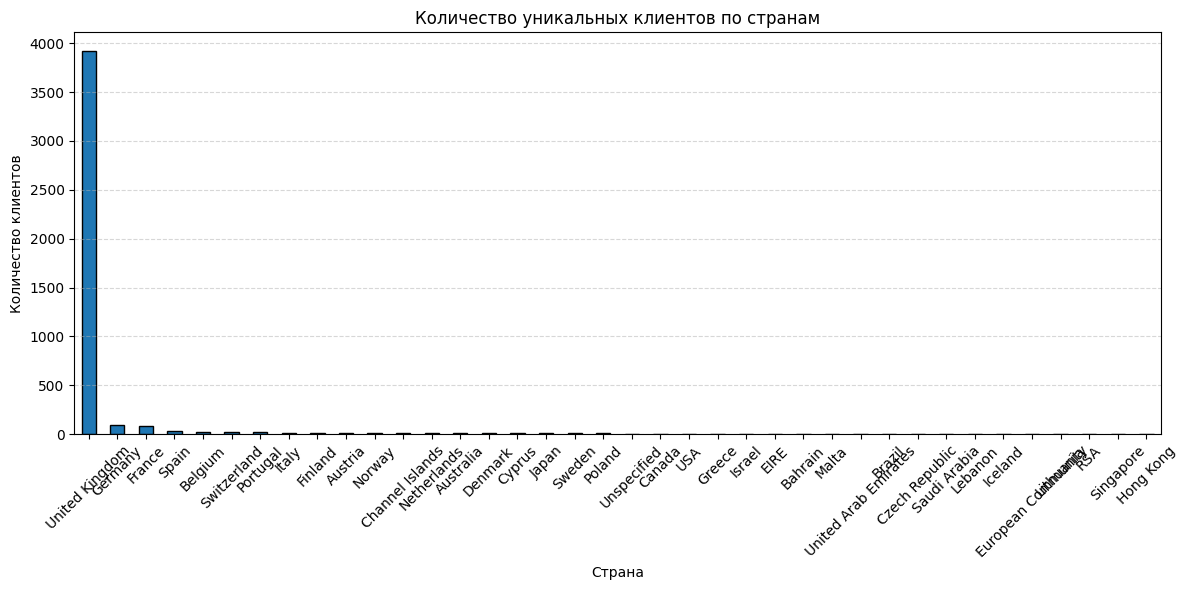

In [ ]:
plt.figure(figsize=(12, 6))
clients_per_country.plot(kind='bar')
plt.title('Количество уникальных клиентов по странам')
plt.ylabel('Количество клиентов')
plt.xlabel('Страна')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Задание 4.2
Мы посмотрели на распределение клиентов в разрезе стран. А что насчёт заказов?

Постройте визуализацию и выделите топ-3 стран по количеству поступающих заказов.

* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


In [ ]:
orders_per_country = data.groupby('Country')['InvoiceNo'].nunique().sort_values(ascending=False)

print("Топ-10 стран по количеству заказов:")
print(orders_per_country.head(10))

Топ-10 стран по количеству заказов:
Country
United Kingdom    17901
Germany             443
France              382
EIRE                282
Belgium              98
Netherlands          93
Spain                88
Australia            56
Portugal             50
Switzerland          50
Name: InvoiceNo, dtype: int64


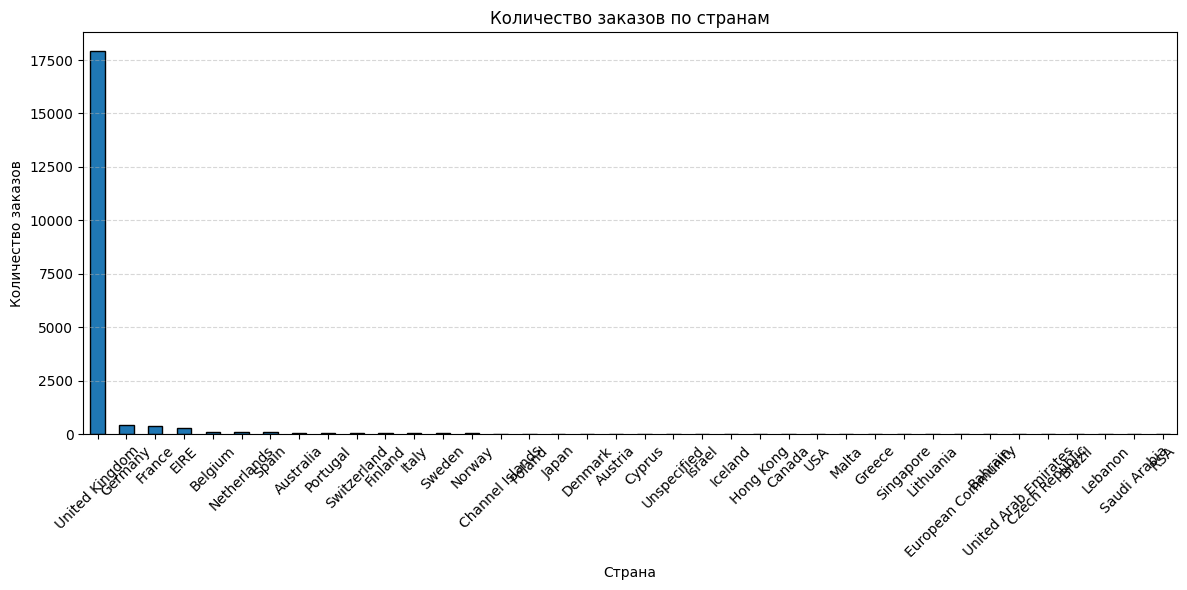

In [ ]:
plt.figure(figsize=(12, 6))
orders_per_country.plot(kind='bar')
plt.title('Количество заказов по странам')
plt.ylabel('Количество заказов')
plt.xlabel('Страна')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Задание 4.3
Давайте добавим в датасет общую цену заказа, назовём её TotalPrice.
Общая цена заказа рассчитывается как:

 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

Чему равна средняя общая стоимость заказов? Ответ приведите в фунтах стерлингов и округлите до целого числа.



In [ ]:
# Убедимся, что колонка есть (если ты её создавал раньше)
if 'QuantityCanceled' not in data.columns:
    data['QuantityCanceled'] = 0  # если не считали, считаем, что возвратов нет

# Добавим TotalPrice
data['TotalPrice'] = data['UnitPrice'] * (data['Quantity'] - data['QuantityCanceled'])

In [ ]:
# Группируем по заказу и считаем сумму TotalPrice по каждой корзине
order_totals = data.groupby('InvoiceNo')['TotalPrice'].sum()

# Считаем среднюю стоимость заказа
average_order_value = order_totals.mean()
print("Средняя общая стоимость заказа:", round(average_order_value))

Средняя общая стоимость заказа: 495


### Задание 4.4

Постройте визуализацию и выделите топ-3 стран, клиенты из которых приносят компании больше всего выручки:
* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


In [ ]:
# Группируем по странам и считаем общую выручку по каждой стране
revenue_per_country = data.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)

# Выведем топ-3 страны
print(revenue_per_country.head(3))

Country
United Kingdom    8286639.08
Netherlands        283443.54
EIRE               260987.66
Name: TotalPrice, dtype: float64


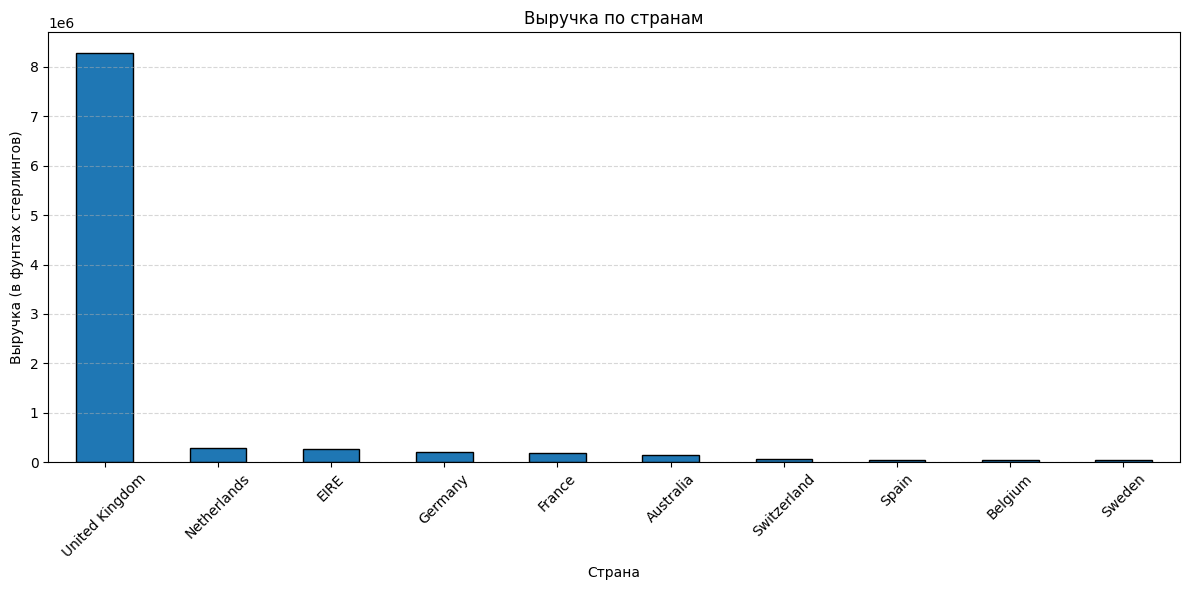

In [ ]:
plt.figure(figsize=(12, 6))
revenue_per_country.head(10).plot(kind='bar')
plt.title('Выручка по странам')
plt.ylabel('Выручка (в фунтах стерлингов)')
plt.xlabel('Страна')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Теперь займёмся временными характеристиками.


### Задание 4.5
Добавьте в таблицу с транзакциями признаки месяца, дня недели и часа совершения покупки.

Постройте визуализацию, отражающую распределение суммарной выручки от заказов по месяцам. Укажите номер самого прибыльного для компании месяца. Предположите, почему так происходит.

In [ ]:
# Извлекаем месяц, день недели и час из 'InvoiceDate'
data['Month'] = data['InvoiceDate'].dt.month
data['Weekday'] = data['InvoiceDate'].dt.weekday
data['Hour'] = data['InvoiceDate'].dt.hour

# Проверим, как это выглядит
print(data[['InvoiceDate', 'Month', 'Weekday', 'Hour']].head())

          InvoiceDate  Month  Weekday  Hour
0 2010-12-01 08:26:00     12        2     8
1 2010-12-01 08:26:00     12        2     8
2 2010-12-01 08:26:00     12        2     8
3 2010-12-01 08:26:00     12        2     8
4 2010-12-01 08:26:00     12        2     8


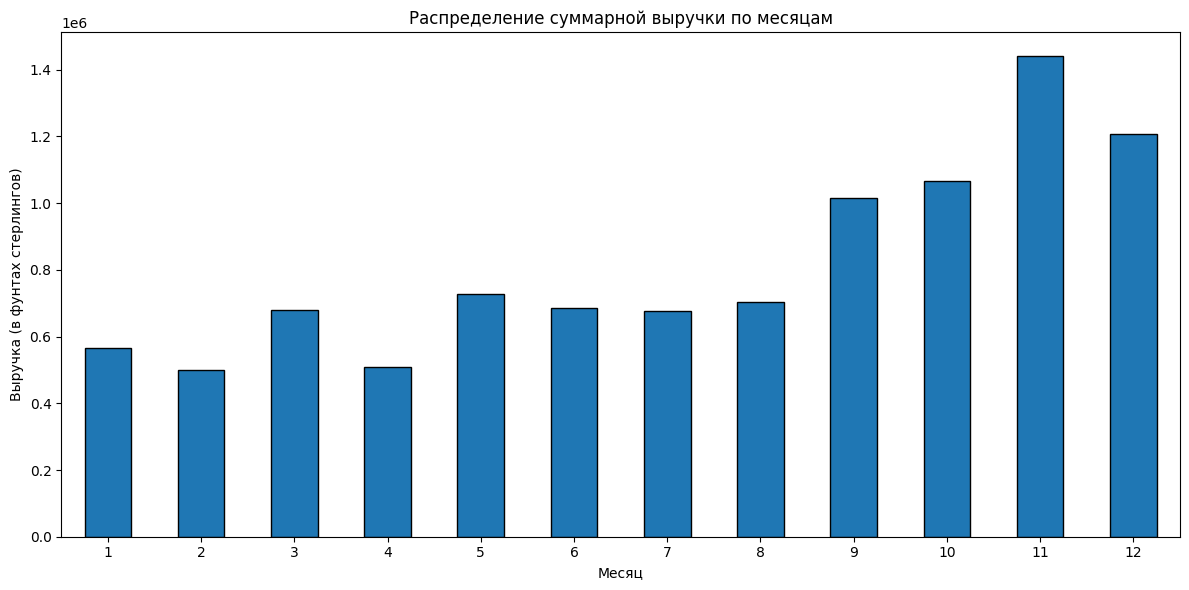

Самый прибыльный месяц: 11


In [ ]:
# Группируем по месяцам и считаем суммарную выручку
revenue_per_month = data.groupby('Month')['TotalPrice'].sum()

# Построим график
plt.figure(figsize=(12, 6))
revenue_per_month.plot(kind='bar')
plt.title('Распределение суммарной выручки по месяцам')
plt.ylabel('Выручка (в фунтах стерлингов)')
plt.xlabel('Месяц')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Выводим месяц с самой высокой выручкой
max_revenue_month = revenue_per_month.idxmax()
print(f"Самый прибыльный месяц: {max_revenue_month}")

### Задание 4.6
Постройте визуализацию количества заказов для каждого дня недели. Укажите день недели, в который, согласно данным, не совершено ни одного заказа:
* Понедельник
* Вторник
* Среда
* Четверг
* Пятница
* Суббота
* Воскресенье


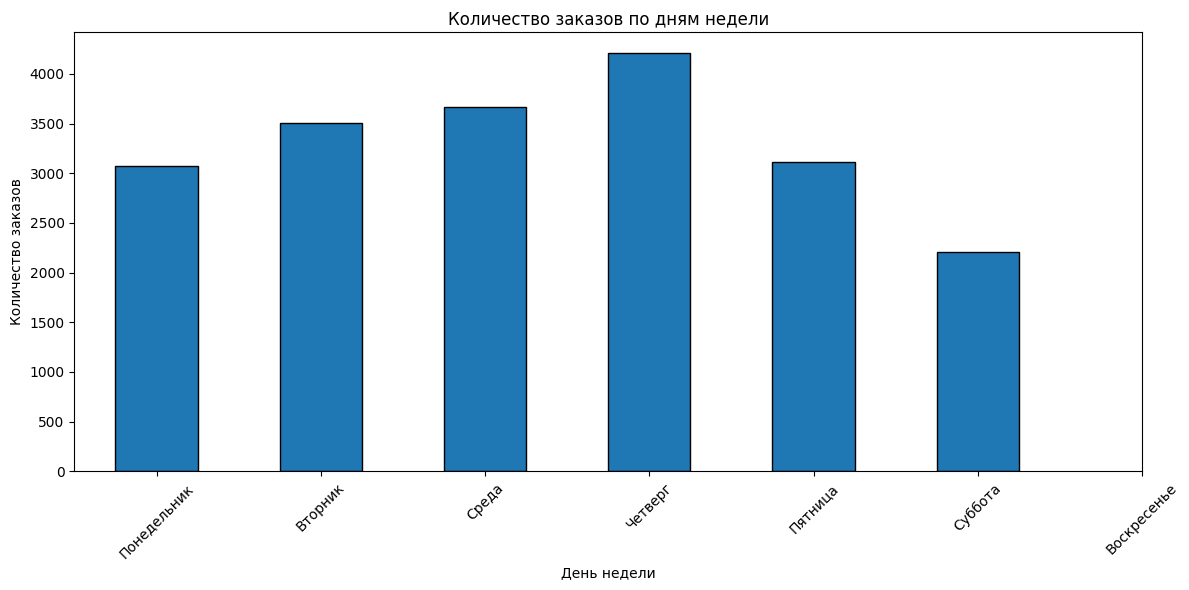

В каждом дне недели были заказы.


In [ ]:
# Группируем данные по дням недели и считаем количество заказов
orders_per_weekday = data.groupby('Weekday')['InvoiceNo'].nunique()

# Построим график
plt.figure(figsize=(12, 6))
orders_per_weekday.plot(kind='bar')
plt.title('Количество заказов по дням недели')
plt.ylabel('Количество заказов')
plt.xlabel('День недели')
plt.xticks(ticks=range(7), labels=['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье'], rotation=45)
plt.tight_layout()
plt.show()

# Проверим, есть ли день, в который не было заказов
no_orders_days = orders_per_weekday[orders_per_weekday == 0]
if no_orders_days.empty:
    print("В каждом дне недели были заказы.")
else:
    no_orders_day = no_orders_days.index[0]
    print(f"День недели, в который не было заказов: {['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье'][no_orders_day]}")

### Задание 4.7
Выделите дату из признака времени совершения транзакции.
Сгруппируйте данные по датам и часам совершения транзакции и найдите количество заказов на каждый день-час. Затем найдите среднее количество ежедневно поступающих заказов в каждый из часов.

Постройте визуализацию, отражающую распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции).

Выберите верные утверждения:
* Больше всего заказов совершается в дневное время в интервале от 18 до 20 часов
* Больше всего заказов совершается в вечернее время в интервале от 10 до 15 часов
* Начиная с 21 часа вечера и до 6 утра (не включительно) заказы не поступают
* Заказы поступают во все периоды дня


In [ ]:
# Извлекаем дату и час из признака времени
data['Date'] = data['InvoiceDate'].dt.date
data['Hour'] = data['InvoiceDate'].dt.hour

# Проверим, как это выглядит
print(data[['InvoiceDate', 'Date', 'Hour']].head())

          InvoiceDate        Date  Hour
0 2010-12-01 08:26:00  2010-12-01     8
1 2010-12-01 08:26:00  2010-12-01     8
2 2010-12-01 08:26:00  2010-12-01     8
3 2010-12-01 08:26:00  2010-12-01     8
4 2010-12-01 08:26:00  2010-12-01     8


In [ ]:
# Группируем по дате и часу, считаем количество заказов
orders_per_day_hour = data.groupby(['Date', 'Hour'])['InvoiceNo'].nunique()

# Найдем среднее количество заказов в каждый час
avg_orders_per_hour = orders_per_day_hour.groupby('Hour').mean()

# Проверим результаты
print(avg_orders_per_hour)

Hour
6      1.000000
7      1.260870
8      2.756098
9      5.837302
10     7.719472
11     7.805921
12    10.508197
13     9.009901
14     8.009934
15     7.674419
16     4.781818
17     3.213592
18     3.490909
19     2.959184
20     1.285714
Name: InvoiceNo, dtype: float64


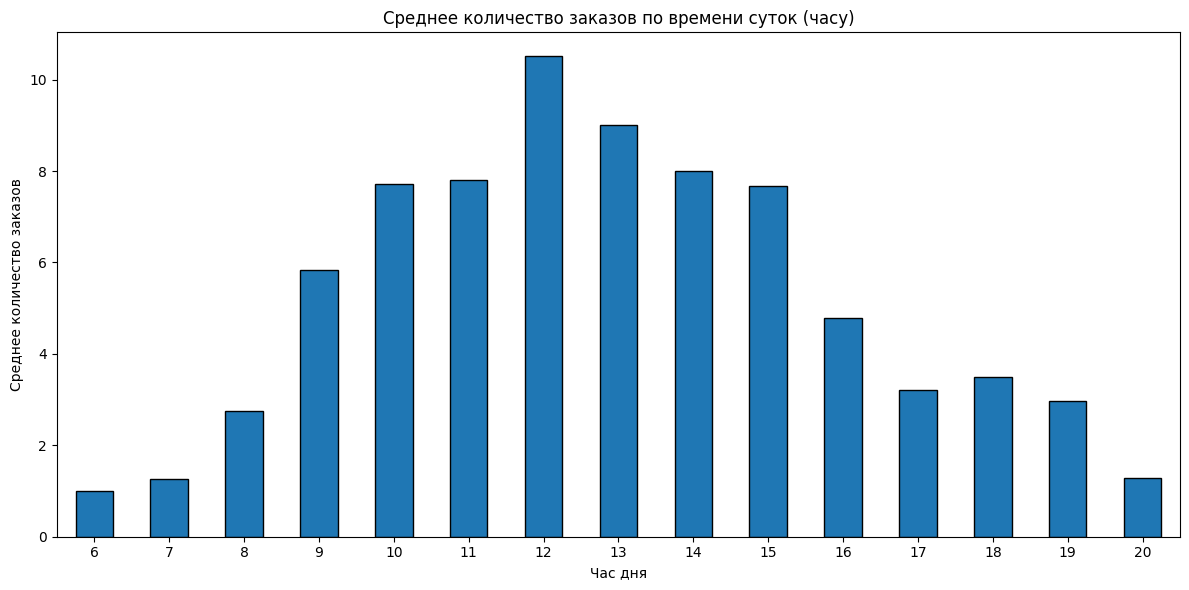

In [ ]:
plt.figure(figsize=(12, 6))
avg_orders_per_hour.plot(kind='bar')
plt.title('Среднее количество заказов по времени суток (часу)')
plt.ylabel('Среднее количество заказов')
plt.xlabel('Час дня')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 5. RFM-сегментация клиентов: часть 1

Мы добрались до самой интересной части нашей задачи. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого давайте познакомимся с очень популярным методом для анализа потребительской ценности под названием RFM.

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов.

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

### Задание 5.1

Итак, приступим к созданию нашей RFM-таблицы.

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учетом возвратов).

Когда вы рассчитаете все характеристики, не забудьте дать столбцам результирующей таблицы соответствующие названия.

In [ ]:
# Точка отсчёта: 10 декабря 2011 года
reference_date = pd.to_datetime('2011-12-10')

# Recency: разница между датой отсчёта и датой последней покупки клиента
recency = data.groupby('CustomerID')['InvoiceDate'].max()
recency = (reference_date - recency).dt.days  # Количество дней с последней покупки

# Frequency: количество уникальных заказов клиента
frequency = data.groupby('CustomerID')['InvoiceNo'].nunique()

# Monetary: общая потраченная сумма, включая возвраты
monetary = data.groupby('CustomerID')['TotalPrice'].sum()

# Создаём итоговую RFM-таблицу
rfm_table = pd.DataFrame({
    'Recency': recency,
    'Frequency': frequency,
    'Monetary': monetary
})

# Проверим, как выглядит таблица
print(rfm_table.head())

            Recency  Frequency  Monetary
CustomerID                              
12346           325          1      0.00
12347             2          7   4310.00
12348            75          4   1437.24
12349            18          1   1457.55
12350           310          1    294.40


1) Сколько клиентов совершили покупку более 200 дней назад?

2) Сколько заказов в среднем делает клиент (за представленный годовой период)? Ответ округлите до целого числа.

3) Чему равна общая сумма денег, которую потратил клиент с идентификатором 12360? Ответ приведите в фунтах стерлингов и округлите до целого числа.



In [ ]:
# Считаем количество клиентов, которые совершили покупку более 200 дней назад
clients_200_days = rfm_table[rfm_table['Recency'] > 200].shape[0]
print("Количество клиентов, совершивших покупку более 200 дней назад:", clients_200_days)

Количество клиентов, совершивших покупку более 200 дней назад: 743


In [ ]:
# Рассчитаем среднее количество заказов
average_orders_per_client = rfm_table['Frequency'].mean()
print("Среднее количество заказов на клиента:", round(average_orders_per_client))

Среднее количество заказов на клиента: 4


In [ ]:
# Выведем несколько случайных клиентов и их суммы
random_customers = rfm_table.sample(5)
print(random_customers[['Monetary']])

            Monetary
CustomerID          
13936         361.28
16384         584.50
13841          85.00
13320        1491.70
12523        1655.57


In [ ]:
# Попробуем найти данные клиента с ID '12360' как строку
monetary_12360 = rfm_table.loc['12360', 'Monetary']
print("Общая сумма, потраченная клиентом 12360:", round(monetary_12360))

Общая сумма, потраченная клиентом 12360: 2302


Теперь давайте взглянем на коробчатые диаграммы для каждого из признаков:

In [ ]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]

fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.show()

Что интересного здесь можно увидеть? Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


### Задание 5.2
Удалите из RFM-таблицы записи о клиентах, для которых выполняется хотя бы одно из условий:

$$frequency >frequency_{0.95}$$
$$monetary >monetary_{0.95}$$

где $frequency_{0.95}$ и $monetary_{0.95}$ - квантили уровня 0.95 для соответствующих признаков.

Данные о скольких клиентах у вас остались в RFM-таблице?


In [ ]:
# Рассчитываем квантили уровня 0.95 для Frequency и Monetary
frequency_95 = rfm_table['Frequency'].quantile(0.95)
monetary_95 = rfm_table['Monetary'].quantile(0.95)

print(f"Квантиль для Frequency (0.95): {frequency_95}")
print(f"Квантиль для Monetary (0.95): {monetary_95}")

Квантиль для Frequency (0.95): 13.0
Квантиль для Monetary (0.95): 5655.2135


In [ ]:
# Удаляем выбросы
rfm_table_filtered = rfm_table[(rfm_table['Frequency'] <= frequency_95) & (rfm_table['Monetary'] <= monetary_95)]

# Смотрим, сколько клиентов осталось
print(f"Количество клиентов после удаления выбросов: {rfm_table_filtered.shape[0]}")

Количество клиентов после удаления выбросов: 4044


После удаления выбросов у вас должны получиться следующие коробчатые диаграммы:


In [ ]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]

fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.show()

Мы наконец добрались до этапа кластеризации. Для начала нам необходимо оценить, как распределены наблюдения в пространстве признаков. Благо, у нас всего три параметра, по которым мы хотим кластеризовать клиентов, поэтому данные можно визуализировать в виде трёхмерной диаграммы рассеяния.

Построим визуализацию нашего трёхмерного пространства признаков:


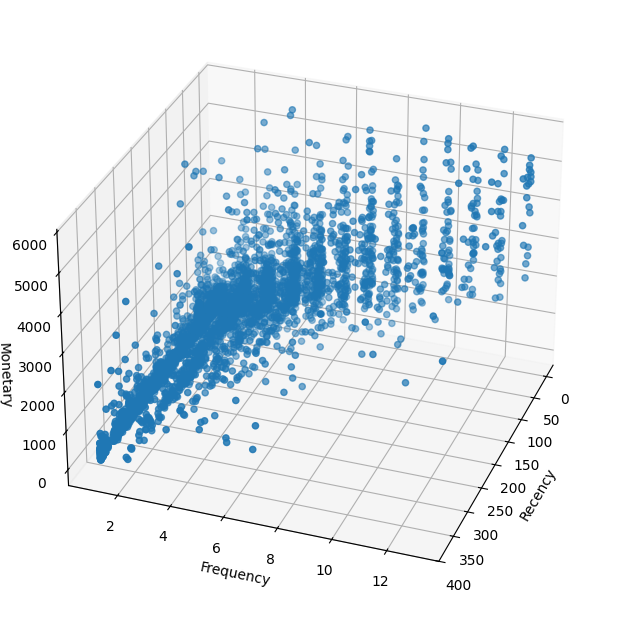

In [ ]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(
    rfm_table_cleaned['Recency'].to_list(),
    rfm_table_cleaned['Frequency'].to_list(),
    rfm_table_cleaned['Monetary'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');


Что здесь можно увидеть? На самом деле, ничего конкретного. Да, видно, что есть клиенты с большими значениями параметров Monetary и Frequency — вероятно, это лучшие клиенты, которые покупают чаще всего и приносят больше всего денег. Однако по общей массе точек сложно сказать, сколько кластеров у нас есть — скорее даже кажется, что пространство не поддаётся кластеризации.

Давайте призовём на помощь методы снижения размерности.


### Задание 5.3
Начнём с метода главных компонент (PCA). Нам известно, что для его стабильной работы данные необходимо стандартизировать/нормализовать.

Давайте для удобства обернём эти шаги по предобработке данных в pipeline.

Создайте pipeline, в котором будут следующие шаги:
* стандартизация с помощью StandardScaler с параметрами по умолчанию;
* метод главных компонент с двумя компонентами.

Обучите ваш pipeline на RFM-таблице, очищенной от выбросов, и примените к ней трансформацию.

Какую долю дисперсии исходных данных объясняет первая главная компонента? Ответ округлите до двух знаков после точки-разделителя.



In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Создаём pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Шаг 1: Стандартизация данных
    ('pca', PCA(n_components=2))   # Шаг 2: PCA с двумя компонентами
])

# Применяем pipeline к данным RFM (очищенным от выбросов)
rfm_scaled = pipeline.fit_transform(rfm_table_cleaned[['Recency', 'Frequency', 'Monetary']])

# Доля дисперсии, объясняемая первой главной компонентой
explained_variance_first_component = pipeline.named_steps['pca'].explained_variance_ratio_[0]
print(f"Доля дисперсии, объясняемая первой главной компонентой: {explained_variance_first_component:.2f}")

Доля дисперсии, объясняемая первой главной компонентой: 0.68


Визуализировав пространство главных компонент после декомпозиции мы получим следующую картину:

In [ ]:
# Создаем DataFrame для визуализации
pca_df = pd.DataFrame(rfm_scaled, columns=['axis-1', 'axis-2'])

# Выведем первые несколько строк
print(pca_df.head())

     axis-1    axis-2
0 -2.136606  1.400695
1  3.440917  0.848613
2  0.626446  0.081654
3  0.150420 -0.723727
4 -1.890513  1.381347


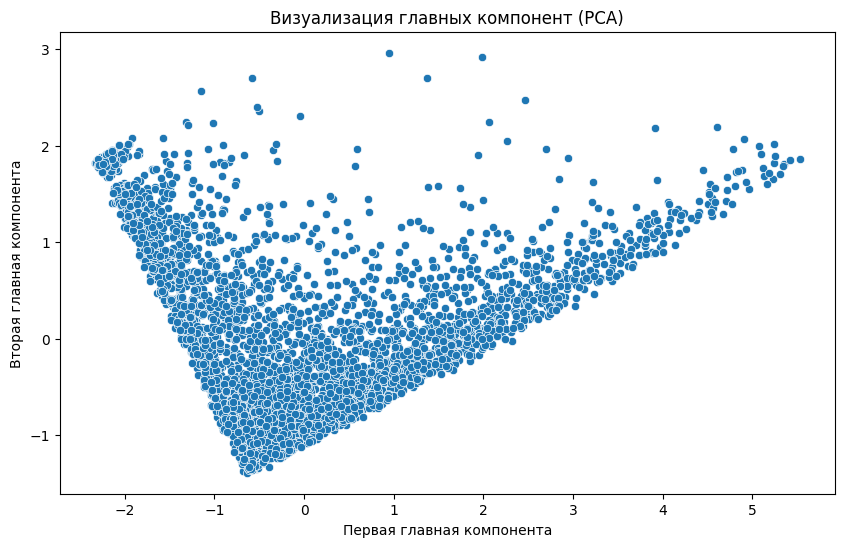

In [ ]:
# Строим scatter plot для визуализации
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='axis-1', y='axis-2')
plt.title('Визуализация главных компонент (PCA)')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.show()

Попробуем разделить это пространство главных компонент на сегменты.

### Задание 5.4
Попробуем воспользоваться методом k-means.

Подберите оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно.

В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.


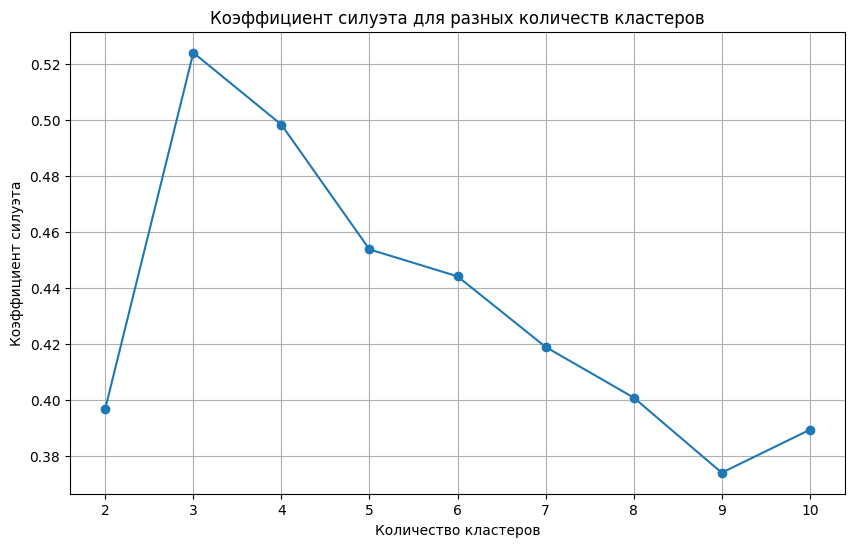

Оптимальное количество кластеров: 3
Максимальное значение коэффициента силуэта: 0.52


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Список для хранения коэффициентов силуэта для разных кластеров
silhouette_scores = []

# Перебираем количество кластеров от 2 до 10
for k in range(2, 11):
    # Применяем k-means с текущим количеством кластеров
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)  # Используем данные, преобразованные через PCA

    # Рассчитываем коэффициент силуэта
    score = silhouette_score(rfm_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Визуализируем результаты
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Коэффициент силуэта для разных количеств кластеров')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

# Находим количество кластеров с максимальным коэффициентом силуэта
optimal_k = range(2, 11)[silhouette_scores.index(max(silhouette_scores))]
max_silhouette_score = max(silhouette_scores)

print(f"Оптимальное количество кластеров: {optimal_k}")
print(f"Максимальное значение коэффициента силуэта: {round(max_silhouette_score, 2)}")

### Задание 5.5
Теперь возьмём EM-алгоритм.

Подберите оптимальное количество кластеров для EM-алгоритма (GaussianMixture) с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно.
В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.


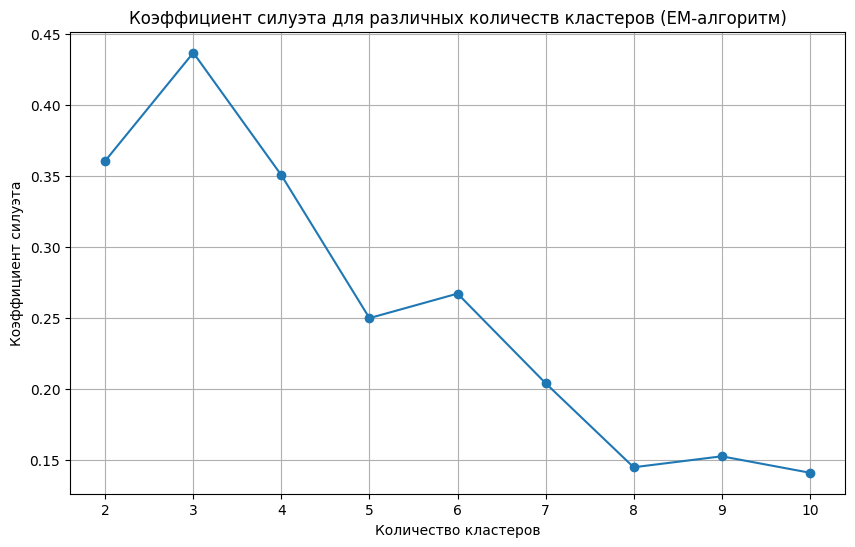

Оптимальное количество кластеров (EM-алгоритм): 3
Максимальное значение коэффициента силуэта: 0.44


In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Список для хранения коэффициентов силуэта для разных кластеров
silhouette_scores_gmm = []

# Перебираем количество кластеров от 2 до 10
for k in range(2, 11):
    # Применяем EM-алгоритм с текущим количеством кластеров
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(rfm_scaled)  # Используем данные, преобразованные через PCA

    # Рассчитываем коэффициент силуэта
    labels = gmm.predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    silhouette_scores_gmm.append(score)

# Визуализируем результаты
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores_gmm, marker='o')
plt.title('Коэффициент силуэта для различных количеств кластеров (EM-алгоритм)')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

# Находим количество кластеров с максимальным коэффициентом силуэта
optimal_k_gmm = range(2, 11)[silhouette_scores_gmm.index(max(silhouette_scores_gmm))]
max_silhouette_score_gmm = max(silhouette_scores_gmm)

print(f"Оптимальное количество кластеров (EM-алгоритм): {optimal_k_gmm}")
print(f"Максимальное значение коэффициента силуэта: {round(max_silhouette_score_gmm, 2)}")

### Задание 5.6
Давайте посмотрим на распределение кластеров.

1) Сначала нужно определить лучшую модель. Для какой модели с оптимальным количеством кластеров коэффициент силуэта наибольший?
* K-Means
* GaussianMixture


2) Обучите лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных.
Сколько клиентов попало в самый большой кластер?



In [ ]:
# Сравниваем коэффициенты силуэта для K-Means и Gaussian Mixture
print(f"Коэффициент силуэта для K-Means: {max(silhouette_scores)}")
print(f"Коэффициент силуэта для GaussianMixture: {max(silhouette_scores_gmm)}")

# Определяем модель с лучшим коэффициентом силуэта
if max(silhouette_scores) > max(silhouette_scores_gmm):
    best_model = "K-Means"
    optimal_k = optimal_k
    silhouette_score_best = max(silhouette_scores)
else:
    best_model = "GaussianMixture"
    optimal_k = optimal_k_gmm
    silhouette_score_best = max(silhouette_scores_gmm)

print(f"Лучшая модель: {best_model}")
print(f"Оптимальное количество кластеров: {optimal_k}")

Коэффициент силуэта для K-Means: 0.524132021589428
Коэффициент силуэта для GaussianMixture: 0.4367998117675316
Лучшая модель: K-Means
Оптимальное количество кластеров: 3


In [ ]:
# Обучаем модель
if best_model == "K-Means":
    model = KMeans(n_clusters=optimal_k, random_state=42)
    model.fit(rfm_scaled)
    labels = model.labels_
else:
    model = GaussianMixture(n_components=optimal_k, random_state=42)
    model.fit(rfm_scaled)
    labels = model.predict(rfm_scaled)

# Добавим метки кластеров в DataFrame
rfm_table_cleaned['Cluster'] = labels

# Найдем самый большой кластер
cluster_sizes = rfm_table_cleaned['Cluster'].value_counts()
largest_cluster_size = cluster_sizes.max()
print(f"Количество клиентов в самом большом кластере: {largest_cluster_size}")

Количество клиентов в самом большом кластере: 2270


Визуализируем результаты кластеризации:

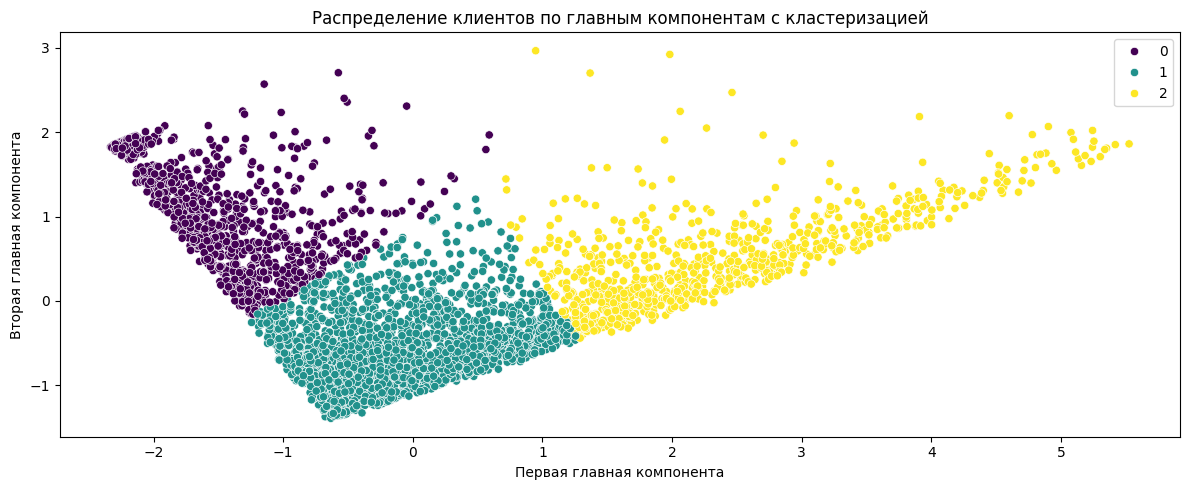

In [ ]:
# Создаем scatter plot с кластеризацией
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=pca_df,
    x='axis-1',
    y='axis-2',
    hue=labels,  # Используем метки кластеров
    palette='viridis',  # Выберите подходящую палитру
    legend='full'
)

# Добавляем название и выводим
plt.title('Распределение клиентов по главным компонентам с кластеризацией')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.tight_layout()
plt.show()

Итак, у нас есть три сегмента клиентов. Давайте попробуем составить профиль для этих сегментов.

### Задание 5.7

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице, очищенной от выбросов.  Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков.

Чему равно максимальное среднее значение признака Frequency в полученной таблице? Ответ округлите до целого числа.

In [ ]:
rfm_table_cleaned['Cluster'] = labels

# Сгруппируем по кластерам и рассчитываем среднее по признакам
cluster_profile = rfm_table_cleaned.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

# Выведем результат
print(cluster_profile)

# Найдем максимальное среднее значение для Frequency
max_frequency = cluster_profile['Frequency'].max()
print(f"Максимальное среднее значение признака Frequency: {round(max_frequency)}")

            Recency  Frequency     Monetary
Cluster                                    
0        253.125498   1.408367   392.896753
1         51.067401   2.331718   666.085855
2         31.389610   7.096104  2667.665208
Максимальное среднее значение признака Frequency: 7


### Полярная диаграмма
Сейчас мы познакомимся с одним из способов визуализации профиля кластеров — Radar Chart (полярная, или лепестковая, диаграмма). Это графическое представление значений нескольких эквивалентных категорий в форме «паутины».
Radar Chart очень часто используется в контексте определения профиля кластеров. На концах «паутины» откладываются оси, которые соответствуют признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник.
Пример полярной диаграммы для задачи кластеризации учеников по интересам:

<img src=https://www.datanovia.com/en/wp-content/uploads/2020/12/radar-chart-in-r-customized-fmstb-radar-chart-1.png width=500>

На данной диаграмме мы видим визуализацию признаков для одного из кластеров. Видно, что ученики, принадлежащие к данному кластеру, в большей степени увлекаются музыкой (Music), а в меньшей степени — программированием (Programm).

В модуле graph_objects библиотеки plotly есть встроенная функция Scatterpolar, которая позволяет построить полярную диаграмму. На основе этой функции мы реализовали собственную функцию plot_cluster_profile(), которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У этой функции два параметра: grouped_data — сгруппированные по кластерам характеристики объектов (клиентов), n_clusters — количество кластеров.

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией мы также добавили в реализацию функции plot_cluster_profile().

In [ ]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()


Теперь у нас есть удобный инструмент для анализа профиля кластеров. Давайте воспользуемся им.


### Задание 5.8

Визуализируйте профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.

Проанализируйте кластеры и на основе анализа сопоставьте номер кластера и его описание.

Описание кластера:
* Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».
* Кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.


In [ ]:
import plotly.graph_objects as go
from sklearn import preprocessing

# Функция для визуализации профиля кластеров
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)

    # Создаем список признаков
    features = grouped_data.columns

    # Создаем пустую фигуру
    fig = go.Figure()

    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values,  # радиусы
            theta=features,  # название засечек
            fill='toself',  # заливка многоугольника цветом
            name=f'Cluster {i}',  # название - номер кластера
        ))

    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True,  # отображение легенды
        autosize=False,  # устаналиваем свои размеры графика
        width=800,  # ширина (в пикселях)
        height=800,  # высота (в пикселях)
    )

    # Отображаем фигуру
    fig.show()

# Используем функцию для визуализации
plot_cluster_profile(cluster_profile, n_clusters=optimal_k)

### 4. RFM-сегментация клиентов: часть 2

Итак, с помощью RFM-анализа нам удалось выделить три сегмента клиентов. Однако в маркетинге принято оперировать большим их количеством: обычно маркетологи стараются создать стратегию хотя бы для пяти-семи клиентских сегментов в градации от «лояльных» до «потерянных» с промежуточными категориями.

Поэтому, получив обратную связь от маркетологов, мы вновь принимаемся за работу, пытаясь модифицировать полученное решение.

Ранее мы производили кластеризацию в пространстве главных компонент. Вспомним, что PCA является линейным методом отображения исходного пространства признаков в его сжатую версию.

А что если использовать нелинейную трансформацию? Например, алгоритм снижения размерности t-SNE. Давайте попробуем и посмотрим, что получится.

### Задание 6.1
Воспользуемся алгоритмом t-SNE и трансформируем RFM-таблицу, очищенную от выбросов, в двухмерное представление. Также заранее позаботимся о масштабировании признаков.

Давайте для удобства обернём шаги по предобработке данных в pipeline.

Создайте pipeline, который будет содержать следующие шаги:
* стандартизация с помощью StandardScaler с параметрами по умолчанию;
* алгоритм t-SNE с двумя компонентами, параметрами perplexity=50 и random_state=100.

Обучите ваш pipeline на RFM-таблице (очищенной от выбросов), полученной ранее, и примените к ней трансформацию.

Чему равно значение дивергенции Кульбака — Лейблера для обученного алгоритма t-SNE? Ответ округлите до двух знаков после точки-разделителя.

**Примечание:**
Напомним, что дивергенция Кульбака-Лейблера - это функция потерь, которая минимизируется при обучения алгоритма t-SNE. Она показывает меру расстояния между двумя распределениями.

Оптимальное значение данной характеристики, найденное в процессе обучения алгоритма t-SNE, хранится в атрибуте kl_divergence_ объекта класса TSNE из библиотеки sklearn. Конечно же, предварительно модель необходимо обучить, чтобы получить это значение.



In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline

# Создаем pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Шаг 1: Стандартизация данных
    ('tsne', TSNE(n_components=2, perplexity=50, random_state=100))  # Шаг 2: t-SNE
])

# Применяем pipeline к данным RFM (очищенным от выбросов)
rfm_tsne = pipeline.fit_transform(rfm_table_cleaned[['Recency', 'Frequency', 'Monetary']])

# Дивергенция Кульбака — Лейблера
kl_divergence = pipeline.named_steps['tsne'].kl_divergence_
print(f"Дивергенция Кульбака — Лейблера: {kl_divergence:.2f}")

Дивергенция Кульбака — Лейблера: 0.54


Визуализировав пространство после декомпозиции с помощью t-SNE, мы получим следующую картину:


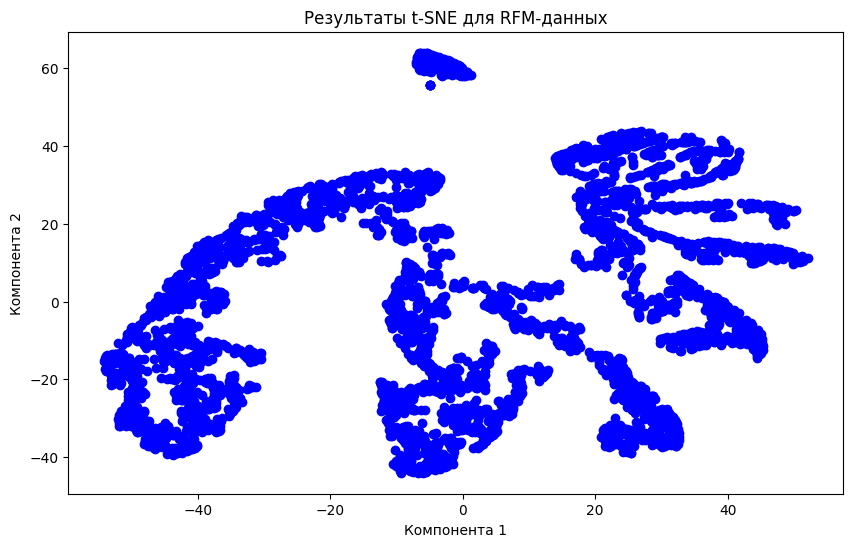

In [ ]:
# Визуализируем результат
plt.figure(figsize=(10, 6))
plt.scatter(rfm_tsne[:, 0], rfm_tsne[:, 1], c='blue', marker='o')
plt.title('Результаты t-SNE для RFM-данных')
plt.xlabel('Компонента 1')
plt.ylabel('Компонента 2')
plt.show()

Как и ожидалось от t-SNE, алгоритм сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры легко определить.

Теперь давайте воспользуемся алгоритмами кластеризации, чтобы сформировать новые сегменты клиентов.


### Задание 6.2
Попробуем воспользоваться методом k-means.
Подберите оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно.
В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.



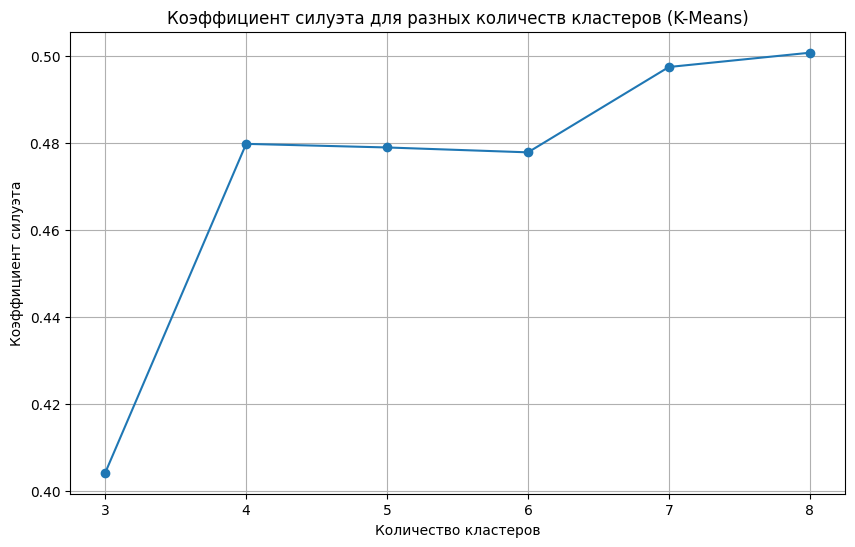

Оптимальное количество кластеров: 8
Максимальное значение коэффициента силуэта: 0.5


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Список для хранения коэффициентов силуэта для разных кластеров
silhouette_scores = []

# Перебираем количество кластеров от 3 до 8
for k in range(3, 9):
    # Применяем k-means с текущим количеством кластеров
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_tsne)  # Используем трансформированные данные через t-SNE

    # Рассчитываем коэффициент силуэта
    score = silhouette_score(rfm_tsne, kmeans.labels_)
    silhouette_scores.append(score)

# Визуализируем результаты
plt.figure(figsize=(10, 6))
plt.plot(range(3, 9), silhouette_scores, marker='o')
plt.title('Коэффициент силуэта для разных количеств кластеров (K-Means)')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.xticks(range(3, 9))
plt.grid(True)
plt.show()

# Находим количество кластеров с максимальным коэффициентом силуэта
optimal_k = range(3, 9)[silhouette_scores.index(max(silhouette_scores))]
max_silhouette_score = max(silhouette_scores)

print(f"Оптимальное количество кластеров: {optimal_k}")
print(f"Максимальное значение коэффициента силуэта: {round(max_silhouette_score, 2)}")

### Задание 6.3
Попробуем воспользоваться EM-алгоритом.

Подберите оптимальное количество кластеров для EM-алгоритма (GaussianMixture)  с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно.

В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.

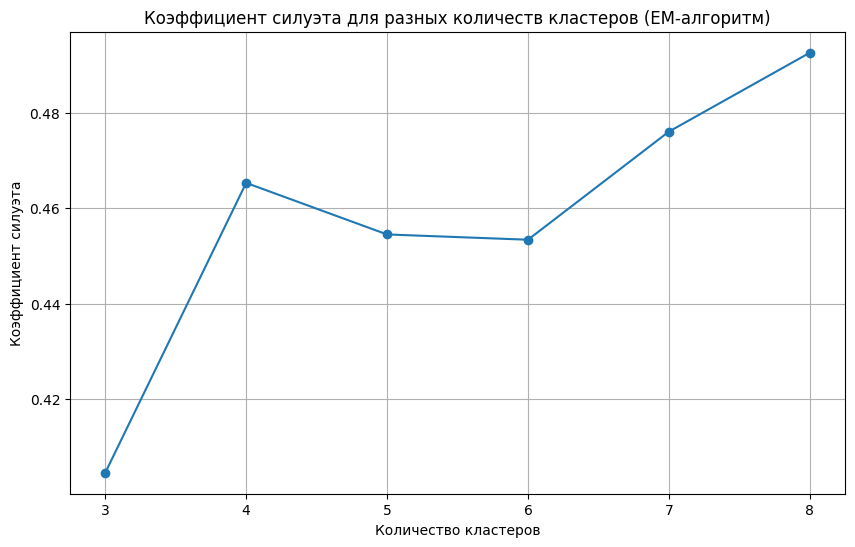

Оптимальное количество кластеров (EM-алгоритм): 8
Максимальное значение коэффициента силуэта: 0.49000000953674316


In [ ]:
# Список для хранения коэффициентов силуэта для разных кластеров
silhouette_scores_gmm = []

# Перебираем количество кластеров от 3 до 8
for k in range(3, 9):
    # Применяем EM-алгоритм с текущим количеством кластеров
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(rfm_tsne)  # Используем трансформированные данные через t-SNE

    # Рассчитываем коэффициент силуэта
    labels = gmm.predict(rfm_tsne)
    score = silhouette_score(rfm_tsne, labels)
    silhouette_scores_gmm.append(score)

# Визуализируем результаты
plt.figure(figsize=(10, 6))
plt.plot(range(3, 9), silhouette_scores_gmm, marker='o')
plt.title('Коэффициент силуэта для разных количеств кластеров (EM-алгоритм)')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.xticks(range(3, 9))
plt.grid(True)
plt.show()

# Находим количество кластеров с максимальным коэффициентом силуэта
optimal_k_gmm = range(3, 9)[silhouette_scores_gmm.index(max(silhouette_scores_gmm))]
max_silhouette_score_gmm = max(silhouette_scores_gmm)

print(f"Оптимальное количество кластеров (EM-алгоритм): {optimal_k_gmm}")
print(f"Максимальное значение коэффициента силуэта: {round(max_silhouette_score_gmm, 2)}")

### Задание 6.4
Наконец, попробуем воспользоваться алгоритмом алгомеративной кластеризации (AgglomerativeClustering).

Подберите оптимальное количество кластеров для алгоритма агломеративной кластеризации с помощью коэффициента силуэта, перебирая возможные значения от 2 до 8 включительно.

Все параметры, за исключением числа кластеров, оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.



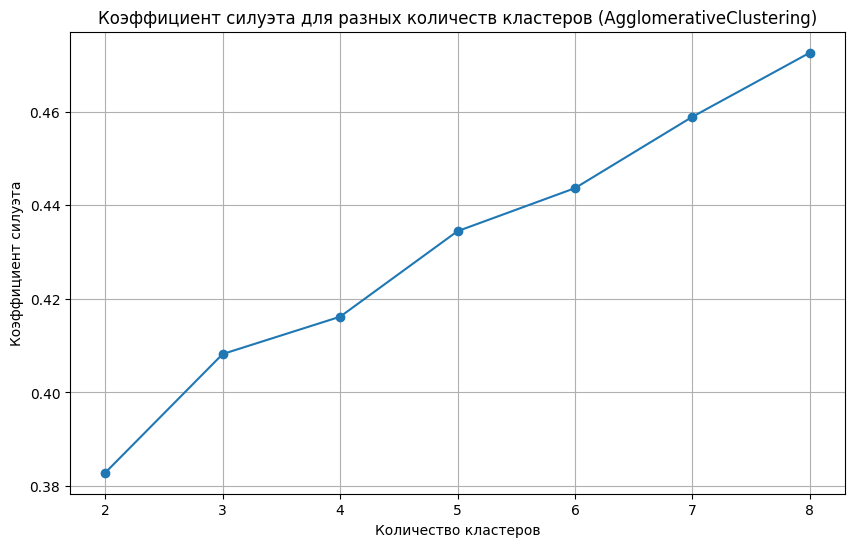

Оптимальное количество кластеров (AgglomerativeClustering): 8
Максимальное значение коэффициента силуэта: 0.4699999988079071


In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Список для хранения коэффициентов силуэта для разных кластеров
silhouette_scores_agglo = []

# Перебираем количество кластеров от 2 до 8
for k in range(2, 9):
    # Применяем алгоритм агломеративной кластеризации с текущим количеством кластеров
    agglo = AgglomerativeClustering(n_clusters=k)
    agglo.fit(rfm_tsne)  # Используем трансформированные данные через t-SNE

    # Рассчитываем коэффициент силуэта
    score = silhouette_score(rfm_tsne, agglo.labels_)
    silhouette_scores_agglo.append(score)

# Визуализируем результаты
plt.figure(figsize=(10, 6))
plt.plot(range(2, 9), silhouette_scores_agglo, marker='o')
plt.title('Коэффициент силуэта для разных количеств кластеров (AgglomerativeClustering)')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.xticks(range(2, 9))
plt.grid(True)
plt.show()

# Находим количество кластеров с максимальным коэффициентом силуэта
optimal_k_agglo = range(2, 9)[silhouette_scores_agglo.index(max(silhouette_scores_agglo))]
max_silhouette_score_agglo = max(silhouette_scores_agglo)

print(f"Оптимальное количество кластеров (AgglomerativeClustering): {optimal_k_agglo}")
print(f"Максимальное значение коэффициента силуэта: {round(max_silhouette_score_agglo, 2)}")

### Задание 6.5
Давайте посмотрим на распределение кластеров.

1) Сначала нужно определить лучшую модель. Для какой модели с оптимальным количеством кластеров коэффициент силуэта наибольший?
* K-Means
* GaussianMixture
* AgglomerativeClustering


2) Обучите лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных.
Сколько клиентов попало в самый большой кластер?



In [ ]:
# Коэффициенты силуэта для K-Means, GMM и AgglomerativeClustering
kmeans_silhouette = max(silhouette_scores)
gmm_silhouette = max(silhouette_scores_gmm)
agglo_silhouette = max(silhouette_scores_agglo)

# Определяем модель с наибольшим коэффициентом силуэта
if kmeans_silhouette > gmm_silhouette and kmeans_silhouette > agglo_silhouette:
    best_model = "K-Means"
    optimal_k = optimal_k
    silhouette_score_best = kmeans_silhouette
elif gmm_silhouette > kmeans_silhouette and gmm_silhouette > agglo_silhouette:
    best_model = "GaussianMixture"
    optimal_k = optimal_k_gmm
    silhouette_score_best = gmm_silhouette
else:
    best_model = "AgglomerativeClustering"
    optimal_k = optimal_k_agglo
    silhouette_score_best = agglo_silhouette

print(f"Лучшая модель: {best_model}")
print(f"Оптимальное количество кластеров: {optimal_k}")
print(f"Максимальное значение коэффициента силуэта: {round(silhouette_score_best, 2)}")

Лучшая модель: K-Means
Оптимальное количество кластеров: 8
Максимальное значение коэффициента силуэта: 0.5


In [ ]:
# Обучаем модель с оптимальным количеством кластеров
if best_model == "K-Means":
    model = KMeans(n_clusters=optimal_k, random_state=42)
    model.fit(rfm_tsne)  # Используем данные, трансформированные через t-SNE
    labels = model.labels_
elif best_model == "GaussianMixture":
    model = GaussianMixture(n_components=optimal_k, random_state=42)
    model.fit(rfm_tsne)  # Используем данные, трансформированные через t-SNE
    labels = model.predict(rfm_tsne)
else:
    model = AgglomerativeClustering(n_clusters=optimal_k)
    model.fit(rfm_tsne)  # Используем данные, трансформированные через t-SNE
    labels = model.labels_

# Добавляем метки кластеров в RFM-таблицу
rfm_table_cleaned['Cluster'] = labels

# Находим самый большой кластер
cluster_sizes = rfm_table_cleaned['Cluster'].value_counts()
largest_cluster_size = cluster_sizes.max()

print(f"Количество клиентов в самом большом кластере: {largest_cluster_size}")

Количество клиентов в самом большом кластере: 776


Визуализируем результаты кластеризации:

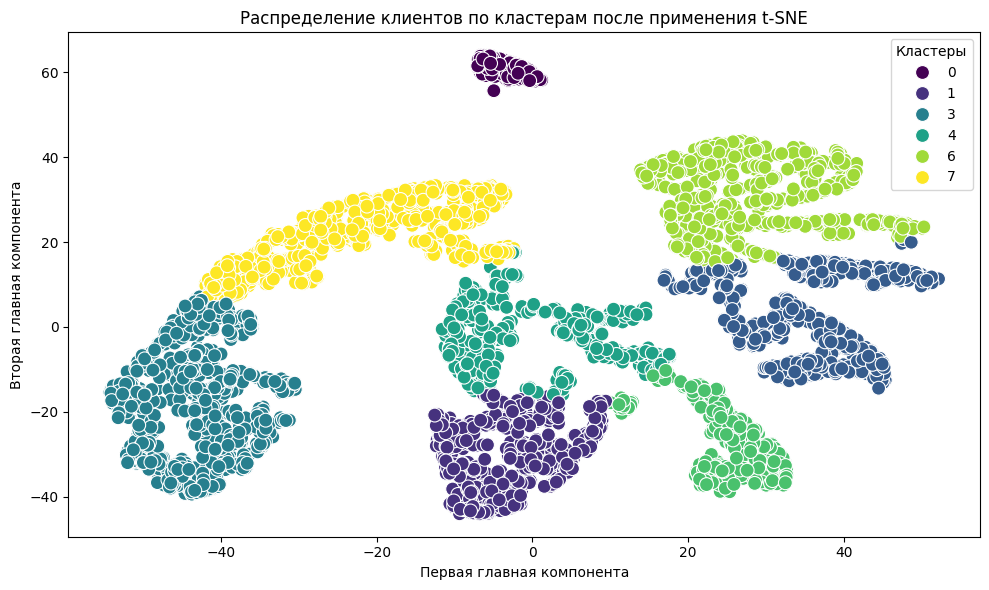

In [ ]:
# Добавляем метки кластеров в DataFrame
rfm_table_cleaned['Cluster'] = labels

# Строим scatter plot для визуализации
plt.figure(figsize=(10, 6))
sns.scatterplot(x=rfm_tsne[:, 0], y=rfm_tsne[:, 1], hue=rfm_table_cleaned['Cluster'], palette='viridis', marker='o', s=100)

plt.title('Распределение клиентов по кластерам после применения t-SNE')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.legend(title="Кластеры")
plt.tight_layout()
plt.show()


Итак, у нас есть 7 сегментов клиентов. Давайте попробуем составить профиль для этих сегментов.


### Задание 6.6

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице (очищенной от выбросов).

Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков. Для наглядности округлите все значения в столбцах до целого числа.

Чему равно максимальное среднее значение признака Recency в полученной таблице? Ответ округлите до целого числа.

In [ ]:
rfm_table_cleaned['Cluster'] = labels  # labels — это метки кластеров, полученные ранее

# Сгруппируем по кластерам и рассчитываем среднее по признакам
cluster_profile = rfm_table_cleaned.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

# Округлим значения до целого числа
cluster_profile = cluster_profile.round()

# Выведем таблицу с результатами
print(cluster_profile)

# Найдем максимальное среднее значение для Recency
max_recency = cluster_profile['Recency'].max()
print(f"Максимальное среднее значение признака Recency: {int(max_recency)}")

         Recency  Frequency  Monetary
Cluster                              
0          365.0        1.0     236.0
1           38.0        2.0     596.0
2           45.0        4.0    1344.0
3           58.0        1.0     323.0
4          175.0        3.0     683.0
5           33.0        3.0     933.0
6           27.0        8.0    2687.0
7          252.0        1.0     323.0
Максимальное среднее значение признака Recency: 365


### Задание 6.7
Визуализируйте профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.

Проанализируйте кластеры и на основе анализа сопоставьте номер кластера и его описание.

* Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.
* Кластер соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».
* Кластер соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад.
* Кластер соответствует клиентам-«новичкам», которые относительно недавно сделали один заказ на небольшую сумму.
* Кластер соответствует «спящим» или «почти потерянным» клиентам, которые сделали один заказ на маленькую сумму более семи месяцев назад и больше не возвращались.
* Кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена около года назад.



In [ ]:
# Функция для визуализации профиля кластеров
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)

    # Создаем список признаков
    features = grouped_data.columns

    # Создаем пустую фигуру
    fig = go.Figure()

    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values,  # радиусы
            theta=features,  # название засечек
            fill='toself',  # заливка многоугольника цветом
            name=f'Cluster {i}',  # название - номер кластера
        ))

    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True,  # отображение легенды
        autosize=False,  # устаналиваем свои размеры графика
        width=800,  # ширина (в пикселях)
        height=800,  # высота (в пикселях)
    )

    # Отображаем фигуру
    fig.show()

# Используем функцию для визуализации
plot_cluster_profile(cluster_profile, n_clusters=optimal_k)

## 7. RFM-кластеризация клиентов: часть 3

Мы построили модель кластеризации для части клиентов.Но как сделать предсказание сегмента для клиентов, которые не попали в обучающую выборку?

Вы, вероятно, скажете: «Воспользоваться методом predict()!»

Верно, однако всё не так просто.

Вспомним, что мы обучали наши алгоритмы кластеризации на сжатом с помощью t-SNE пространстве признаков. То есть, чтобы сделать предсказание для новых объектов, не попавших в выборку, нам необходимо будет совершить трансформацию признаков этих объектов в новое сжатое пространство.

Однако проблема t-SNE заключается в том, что алгоритм непараметрический. Это значит, что он, в отличие от таких алгоритмов, как PCA и SVD, не создаёт явной функции отображения. Проще говоря, алгоритм трансформирует пространство признаков для обучающей выборки, но не запоминает, каким образом это делает. Это значит, что, передав в алгоритм новые объекты для сжатия пространства, мы получим абсолютно новое представление пространства, не имеющее отношения к тому, что мы построили для обучающей выборки. То есть произойдёт искажение, что может привести к неверным результатам кластеризации.

Именно поэтому у класса TSNE из библиотеки sklearn нет такого метода, как transform(), у него есть только метод fit_transform() — заново обучить алгоритм t-SNE и произвести трансформацию.

Как же тогда производить кластеризацию для новых объектов, если мы не можем сжимать размерность для новых данных?

Давайте сведём задачу кластеризации к задаче классификации. Действительно, у нас теперь есть истинные метки кластеров, а есть клиенты, которые описываются RFM-характеристиками. Давайте обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент.

### Задание 7.1

Разделите исходные данные на тренировочную и тестовую выборки в соотношении 80/20. В качестве параметра random_state возьмите число 42.

Сколько клиентов попали в тестовую выборку?

In [ ]:
from sklearn.model_selection import train_test_split

# Разделяем данные на тренировочную и тестовую выборки в соотношении 80/20
X = rfm_table_cleaned[['Recency', 'Frequency', 'Monetary']]  # Признаки (RFM-характеристики)
y = rfm_table_cleaned['Cluster']  # Целевая переменная (кластер)

# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Количество клиентов, попавших в тестовую выборку
num_clients_test = X_test.shape[0]
print(f"Количество клиентов в тестовой выборке: {num_clients_test}")

Количество клиентов в тестовой выборке: 809


Дальше нам осталось только построить несколько моделей и выбрать из них лучшую.
Мы знаем, что алгоритм t-SNE является нелинейным методом понижения размерности. Можно смело предположить, что линейные модели, такие как логистическая регрессия, в данной задаче нам мало чем помогут (можете убедиться в этом самостоятельно, обучив модель логистической регрессии на тренировочной выборке и оценив качество на тестовой).

Поэтому давайте сразу возьмём тяжелую артиллерию — ансамблевые алгоритмы.


### Задание 7.2
Начнём со случайного леса. С помощью GridSearchCV организуйте перебор параметров случайного леса (RandomForestClassifier) на следующей сетке параметров:

```
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}
```
В качестве параметра random_state для модели случайного леса используйте число 42.
В качестве метрики используйте accuracy. Количество фолдов для кросс-валидации — 5.

1) Обучите GridSearchCV на тренировочной выборке. Чему равна оптимальная максимальная глубина деревьев в случайном лесу?

2) С помощью лучшей модели сделайте предсказание для тестовой выборки и рассчитайте метрику accuracy. Ответ округлите до трёх знаков после точки-разделителя.



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Определяем сетку параметров для перебора
param_grid = {
    'max_depth': range(5, 15),  # Возможные значения глубины деревьев
    'criterion': ['gini', 'entropy'],  # Критерии для разделения
    'n_estimators': [100, 200, 500]  # Количество деревьев
}

# Создаём объект RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Создаём объект GridSearchCV для подбора параметров
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

# Обучаем GridSearchCV на тренировочной выборке
grid_search.fit(X_train, y_train)

# Оптимальные параметры модели
best_params = grid_search.best_params_
print(f"Оптимальная максимальная глубина деревьев: {best_params['max_depth']}")

# Получаем лучшую модель после подбора параметров
best_rf_model = grid_search.best_estimator_

# Предсказание для тестовой выборки
y_pred = best_rf_model.predict(X_test)

# Рассчитываем accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Метрика accuracy для тестовой выборки: {round(accuracy, 3)}")

Оптимальная максимальная глубина деревьев: 10
Метрика accuracy для тестовой выборки: 0.99


Итак, значение метрики accuracy очень высокое, но не идеальное. Давайте попробуем его улучшить, воспользовавшись бустингом.

### Задание 7.3
С помощью GridSearchCV организуйте перебор параметров градиентного бустинга (GradientBoostingClassifier) на следующей сетке параметров:
```
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}
```

В качестве параметра random_state для модели градиентного бустинга используйте число 42.
В качестве метрики используйте accuracy. Количество фолдов для кросс-валидации — 5.

1) Обучите GridSearchCV на тренировочной выборке. Чему равна оптимальная максимальная глубина деревьев в градиентном бустинге?
Ответ: 6
2) С помощью лучшей модели сделайте предсказание для тестовой выборки и рассчитайте метрику accuracy. Ответ округлите до трёх знаков после точки-разделителя.



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Сетку параметров для перебора
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}

# Создаем объект GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)

# Создаем объект GridSearchCV
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Обучаем модель
grid_search_gb.fit(X_train, y_train)

# Оптимальная максимальная глубина деревьев
best_params_gb = grid_search_gb.best_params_
print(f"Оптимальная максимальная глубина деревьев: {best_params_gb['max_depth']}")

# Получаем лучшую модель
best_gb_model = grid_search_gb.best_estimator_

# Предсказания для тестовой выборки
y_pred_gb = best_gb_model.predict(X_test)

# Рассчитываем метрику accuracy
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Метрика accuracy для тестовой выборки: {round(accuracy_gb, 3)}")

Оптимальная максимальная глубина деревьев: 4
Метрика accuracy для тестовой выборки: 0.98


Отлично, мы справились с проблемой непараметричности t-SNE и смогли перейти от решения задачи кластеризации к задаче классификации. Теперь у нас есть модель, которая на основе RFM-характерик клиента автоматически определяет его сегмент.

✅ 1. Предобработка данных:

    Успешно подготовили данные, очистив их от пропусков, дубликатов и выбросов.

    Сделали необходимые преобразования и создал полезные признаки для дальнейшего анализа.

✅ 2. Анализ данных:

    Провели разведывательный анализ данных (EDA), определив важные особенности данных и их распределения.

    Изучили и визуализировали распределение клиентов по странам и заказам, определил сезонные и временные тренды.

✅ 3. Сегментация клиентов с помощью RFM:

    Рассчитали ключевые RFM-характеристики для каждого клиента, что позволило выявить различные сегменты клиентов.

    Произвели кластеризацию клиентов с помощью различных методов (K-Means, Gaussian Mixture, Agglomerative Clustering).

    Построили профили кластеров с помощью полярных диаграмм и проанализировали их.

✅ 4. Построение модели классификации:

    Перешли от задачи кластеризации к задаче классификации, обучив модели для предсказания сегмента клиентов на основе их RFM-характеристик.

    Применили RandomForestClassifier и GradientBoostingClassifier с использованием GridSearchCV для подбора оптимальных параметров моделей.

    Получили высокую accuracy для модели (0.98), что подтверждает хорошее качество классификации.

✅ 5. Выводы:

    Мы успешно перешли от задачи кластеризации к задаче классификации, создав модель, которая может предсказывать сегменты клиентов на основе их поведения.

    Модели RandomForest и GradientBoosting показали хорошие результаты.

    В результате кластеризации и построения моделей удалось классифицировать клиентов и разработать профили для разных сегментов, что является важным для маркетинга и стратегического планирования.